In [1]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using %s' % device)

import numpy as np
import h5py
import sys
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.table import Table
from matplotlib import mlab as mlab
from astroNN.shared.matplotlib import pylab_style
pylab_style(paper=True)

sys.path.append('..')
from xp_vae.model import ScatterVAE

torch.cuda.empty_cache()

import matplotlib as mpl

Using cpu


## Load model

In [2]:
from xp_vae.model import ScatterVAE

model = ScatterVAE().to(device)
weights = torch.load('../models/APOGEE_MODEL/weight.pt',map_location='cpu')
model.load_state_dict(state_dict=weights['model_state_dict'])
model.eval()

ScatterVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=110, out_features=90, bias=True)
      (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=90, out_features=70, bias=True)
      (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Linear(in_features=70, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (4): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): Batc

## Make catalogs

In [31]:
APOGEE_XP_XMATCH_PATH = '../data//xp_apogee_cat.h5'
f = h5py.File(APOGEE_XP_XMATCH_PATH,'r')['__astropy_table__']

# flux normalization
g_flux = f['phot_g_mean_flux'][:,np.newaxis]
xp = f['coeffs']/g_flux
xp_err = f['coeff_errs']/g_flux

# standard normalization
norm = np.load('../data/apogee_norm.npz')
xp_norm = (xp - norm['mu']) / norm['sig']
xp_err_norm = xp_err / norm['sig']

# stellar labels + redenning
teff = f['TEFF']
logg = f['LOGG']
m_h = f['M_H']
sfd_ebv = f['SFD_EBV']
alpha_m = f['ALPHA_M']

# errors
teff_err = f['TEFF_ERR']
logg_err = f['LOGG_ERR']
m_h_err = f['M_H_ERR']
alpha_m_err = f['ALPHA_M_ERR']

# other data for cuts
bp_rp = f['GAIAEDR3_PHOT_BP_MEAN_MAG'] - f['GAIAEDR3_PHOT_RP_MEAN_MAG']
mean_mag = f['GAIAEDR3_PHOT_G_MEAN_MAG']
starflag = f['STARFLAG']
aspcapflag = f['ASPCAPFLAG']

In [4]:
from sklearn.model_selection import train_test_split
validation_split = 0.1 # default value

# split up xp data to match training (see xp_vae.model.fit), by index
idx = np.arange(len(xp))
idx_train,idx_val = train_test_split(idx,test_size=validation_split,random_state=12345)

In [5]:
from astroNN.apogee import allstar, bitmask_boolean
aspcap_cut = ~bitmask_boolean(aspcapflag, [2, 3])[0]

# PRISTINE LABELS CATALOG
bp_rp_cut = (bp_rp > 0.) & (bp_rp < 4.)
mag_cut = (mean_mag > 6.) & (mean_mag < 17.5)
star_cut = starflag == 0
teff_cut = (teff/teff_err)> 100
logg_cut = logg_err<.1
m_h_cut = m_h_err<.05
pristine_idx = ( teff_cut & logg_cut & m_h_cut & bp_rp_cut & mag_cut & star_cut & aspcap_cut)
print('Size of pristine labels catalog is %s' % sum(pristine_idx))
print('Good/full = %.2f' % (sum(pristine_idx)/len(teff)))
print('Teff cut removes %s stars' % sum(~teff_cut))
print('logg cut removes %s stars' % sum(~logg_cut))
print('[M/H] cut removes %s stars' % sum(~m_h_cut))

Size of pristine labels catalog is 123804
Good/full = 0.25
Teff cut removes 273466 stars
logg cut removes 286191 stars
[M/H] cut removes 33769 stars


In [6]:
teff_use = teff[pristine_idx]
logg_use = logg[pristine_idx]
m_h_use = m_h[pristine_idx]
alpha_m_use = alpha_m[pristine_idx]

## Project into latent space

In [7]:
norm = np.load('../data/apogee_norm.npz')
torch.cuda.empty_cache()

in1 = torch.from_numpy(xp_norm).cpu().to(device)
in2 = torch.from_numpy(xp_err_norm).to(device)

_,_,mu,log_var,est,s = model.forward(in1,in2)

est = est.detach().cpu().numpy()*norm['sig']+norm['mu']
s = s.detach().cpu().numpy()*norm['sig']
latent = model.reparam(mu.cpu().to(device),log_var.cpu().to(device)).cpu().detach().numpy()

In [8]:
latent_use = latent[pristine_idx]

## [$\alpha$/M] tracks

In [9]:
fe_h = f['FE_H']
mg_fe = f['MG_FE']

In [10]:
# REDEFINE M --> FE and alpha --> Mg since that is what Aarya used to define her track
fe_h_use = fe_h[pristine_idx]
mg_fe_use = mg_fe[pristine_idx]

m_h_use = m_h[pristine_idx]
alpha_m_use = alpha_m[pristine_idx]

# Patil et al. (2023) https://arxiv.org/pdf/2306.09319.pdf

def patil_fit(x):
    return 0.1754*x**3. + 0.1119*x**2. - 0.1253*x + 0.1353

patil_mask = mg_fe_use>patil_fit(fe_h_use)

In [11]:
# [alpha/M] tracks

alpha_m_unc = 0.2
num_alpha_m = 8
dd=0.2
alpha_m_grid_high = np.linspace(min(alpha_m_use[patil_mask])+dd,max(alpha_m_use[patil_mask])-dd,num_alpha_m)
alpha_m_grid_low = np.linspace(min(alpha_m_use[~patil_mask])+dd,max(alpha_m_use[~patil_mask])-dd,num_alpha_m)

m_h_unc = 0.1
num_m_h = 8
dd = 0.2
m_h_grid_high = np.linspace(min(m_h_use[patil_mask])+dd,max(m_h_use[patil_mask])-dd,num_m_h)
m_h_grid_low = np.linspace(min(m_h_use[~patil_mask])+dd,max(m_h_use[~patil_mask])-dd,num_m_h)

alpha_mask1 = np.array([[(np.abs(m_h_use-m_h_i)<m_h_unc)*(np.abs(alpha_m_use-alpha_m_j)<alpha_m_unc)*patil_mask \
                          for alpha_m_j in alpha_m_grid_high] for m_h_i in m_h_grid_high])

high_alpha_tracks = np.zeros((num_m_h,num_alpha_m,2))

for i in range(num_m_h):
    for j in range(num_alpha_m):
        mh_ij = np.mean(m_h_use[alpha_mask1[i,j]])
        am_ij = np.mean(alpha_m_use[alpha_mask1[i,j]])
        high_alpha_tracks[i,j] = np.array([mh_ij,am_ij])

alpha_mask2 = np.array([[(np.abs(m_h_use-m_h_i)<m_h_unc)*(np.abs(alpha_m_use-alpha_m_j)<alpha_m_unc)*~patil_mask \
                         for alpha_m_j in alpha_m_grid_low] for m_h_i in m_h_grid_low])

low_alpha_tracks = np.zeros((num_m_h,num_alpha_m,2))

for i in range(num_m_h):
    for j in range(num_alpha_m):
        mh_ij = np.mean(m_h_use[alpha_mask2[i,j]])
        am_ij = np.mean(alpha_m_use[alpha_mask2[i,j]])
        low_alpha_tracks[i,j] = np.array([mh_ij,am_ij])

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
# pure alpha track
alpha_m_unc = 0.05
num_alpha_m = 8
dd=0.
alpha_m_grid = np.linspace(0,0.4,num_alpha_m)

fixed_m_h = -0.4
m_h_unc = 0.2
num_m_h = 8

alpha_mask3 = np.array([(np.abs(m_h_use-fixed_m_h)<m_h_unc)*(np.abs(alpha_m_use-alpha_m_j)<alpha_m_unc) \
                          for alpha_m_j in alpha_m_grid])

fixed_m_h_track = np.zeros((num_alpha_m,2))

for i in range(num_alpha_m):
    mh_ij = fixed_m_h
    am_ij = np.mean(alpha_m_use[alpha_mask3[i]])
    fixed_m_h_track[i] = np.array([mh_ij,am_ij])

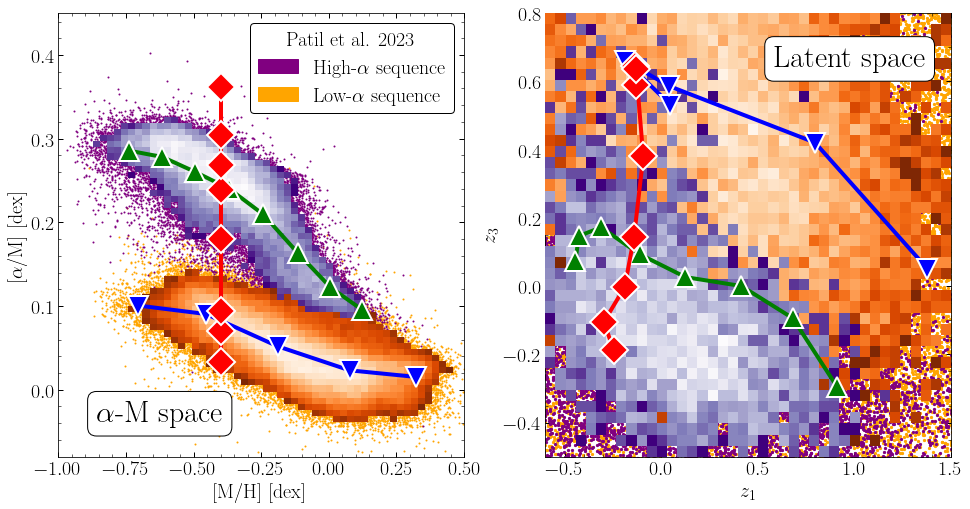

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

bins=91
s = 200
lw = 4
m_h_grid = np.linspace(min(m_h_use),max(m_h_use),bins)
alpha_m_grid = np.linspace(min(alpha_m_use),max(alpha_m_use),bins)

# low alpha sequence
ax[0].hist2d(m_h_use[~patil_mask],alpha_m_use[~patil_mask],bins=[m_h_grid,alpha_m_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Oranges_r',zorder=2)
ax[0].scatter(m_h_use[~patil_mask],alpha_m_use[~patil_mask],s=1,color='orange',zorder=1)
# high alpha sequence
ax[0].hist2d(m_h_use[patil_mask],alpha_m_use[patil_mask],bins=[m_h_grid,alpha_m_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Purples_r',zorder=2)
ax[0].scatter(m_h_use[patil_mask],alpha_m_use[patil_mask],s=1,color='purple',zorder=1)

# create the new map
c = np.arange(1.,num_m_h+1.)
cmap3 = plt.cm.get_cmap('seismic',len(c))
norm = mpl.colors.BoundaryNorm(np.arange(len(c)+1)+0.5,len(c))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap3)

mh_track,am_track = high_alpha_tracks[:,0].T
ax[0].plot(mh_track,am_track,marker='^',zorder=4,markersize=20,color='green',linestyle='-',lw=lw,markeredgecolor='w',markeredgewidth=2)

mh_track,am_track = low_alpha_tracks[:,-1].T
ax[0].plot(mh_track,am_track,marker='v',zorder=4,markersize=20,color='blue',linestyle='-',lw=lw,markeredgecolor='w',markeredgewidth=2) 

# fixed [M/H] sequence
mh_track,am_track = fixed_m_h_track.T
ax[0].plot(mh_track,am_track,marker='D',zorder=4,markersize=20,color='red',linestyle='-',lw=lw,markeredgecolor='w',markeredgewidth=2) 

ax[0].set_xlim(-1.0,0.5)
ax[0].set_ylim(-0.08,0.45)

ax[0].set_ylabel(r'[$\alpha$/M] [dex]')
ax[0].set_xlabel(r'[M/H] [dex]')

import matplotlib.patches as mpatches
p_patch = mpatches.Patch(color='purple', label=r'High-$\alpha$ sequence')
o_patch = mpatches.Patch(color='orange', label=r'Low-$\alpha$ sequence')
leg = ax[0].legend(handles=[p_patch, o_patch],framealpha=1.,loc='upper right',title='Patil et al. 2023',fontsize=20)
leg.get_frame().set_edgecolor('k')
leg.get_title().set_fontsize('20')

# NOW PLOT ALPHA-M TRACKS IN LATENT SPACE

dim1,dim2 = 0,2
gridx = np.linspace(-0.6,1.5,41)
gridy = np.linspace(-0.5,0.8,41)

ax[1].hist2d(latent_use[:,dim1][~patil_mask],latent_use[:,dim2][~patil_mask],bins=[gridx,gridy],cmin=15,norm=colors.PowerNorm(0.5),cmap='Oranges_r',zorder=3)
ax[1].scatter(latent_use[:,dim1][~patil_mask],latent_use[:,dim2][~patil_mask],s=5,color='orange',zorder=1)
ax[1].hist2d(latent_use[:,dim1][patil_mask],latent_use[:,dim2][patil_mask],bins=[gridx,gridy],cmin=15,norm=colors.PowerNorm(0.5),cmap='Purples_r',zorder=4)
ax[1].scatter(latent_use[:,dim1][patil_mask],latent_use[:,dim2][patil_mask],s=5,color='purple',zorder=2)

# low alpha
low_alpha_tracks2 = np.zeros((num_m_h,num_alpha_m,2))
for ii in range(num_m_h):
    for jj in range(num_alpha_m):
        l_i = np.mean(latent_use[:,dim1][alpha_mask2[ii,jj]])
        l_j = np.mean(latent_use[:,dim2][alpha_mask2[ii,jj]])
        low_alpha_tracks2[ii,jj] = np.array([l_i,l_j])
l_i_track,l_j_track = low_alpha_tracks2[:,-1].T
ax[1].plot(l_i_track,l_j_track,marker='v',markersize=20,color='blue',linestyle='-',lw=lw,markeredgecolor='w',markeredgewidth=2,zorder=19) 

# high alpha
high_alpha_tracks2 = np.zeros((num_m_h,num_alpha_m,2))
for ii in range(num_m_h):
    for jj in range(num_alpha_m):
        l_i = np.mean(latent_use[:,dim1][alpha_mask1[ii,jj]])
        l_j = np.mean(latent_use[:,dim2][alpha_mask1[ii,jj]])
        high_alpha_tracks2[ii,jj] = np.array([l_i,l_j])
l_i_track,l_j_track = high_alpha_tracks2[:,0].T
ax[1].plot(l_i_track,l_j_track,marker='^',markersize=20,color='green',linestyle='-',lw=lw,markeredgecolor='w',markeredgewidth=2,zorder=20) 

# fixed [M/H]
fixed_m_h_tracks2 = np.zeros((num_alpha_m,2))
for ii in range(num_alpha_m):
    l_i = np.mean(latent_use[:,dim1][alpha_mask3[ii]])
    l_j = np.mean(latent_use[:,dim2][alpha_mask3[ii]])
    fixed_m_h_tracks2[ii] = np.array([l_i,l_j])
l_i_track,l_j_track = fixed_m_h_tracks2.T
ax[1].plot(l_i_track,l_j_track,marker='D',markersize=20,color='red',linestyle='-',lw=lw,markeredgecolor='w',markeredgewidth=2,zorder=21) 

ax[1].set_xlabel(r'$z_{%s}$' % (dim1+1),fontsize=20)
ax[1].set_ylabel(r'$z_{%s}$' % (dim2+1),fontsize=20)

bbox=dict(facecolor='w', edgecolor='k', boxstyle='round')
ax[0].text(0.25,0.08,r'$\alpha$-M space',transform=ax[0].transAxes,fontsize=30,ha='center',bbox=bbox)
ax[1].text(0.75,0.88,r'Latent space',transform=ax[1].transAxes,fontsize=30,ha='center',bbox=bbox)

plt.savefig('../figures/alpha_bimodality.png',dpi=400,bbox_inches='tight')
plt.show()

### Train classifier on latent dimensions

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

n_alpha = len(latent_use)
X = latent_use
y = ~patil_mask.astype(int) # flip the mask so that it is ordered high then low

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=.1)
vae_classifier = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [15]:
train_idx,test_idx = train_test_split(np.arange(len(X)),random_state=0,test_size=.1)

In [16]:
latent_predictions = vae_classifier.predict(X_test)
accuracy = vae_classifier.score(X_test, y_test) 

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, latent_predictions) 

In [17]:
accuracy,cm/len(test_idx)

(0.835150634036023,
 array([[0.16073015, 0.11703417],
        [0.0478152 , 0.67442048]]))

### Perfect classification

In [18]:
cm_perfect = np.zeros((2,2))
cm_perfect[1,1] = sum(~patil_mask[test_idx])
cm_perfect[0,0] = sum(patil_mask[test_idx])
cm_perfect/len(test_idx)

array([[0.27776432, 0.        ],
       [0.        , 0.72223568]])

### Only train on [M/H]

In [19]:
n_alpha = len(latent_use)
X2 = m_h_use.reshape(-1,1)
y2 = ~patil_mask.astype(int)

X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,random_state=0,test_size=.1)
metallicity_classifier = RandomForestClassifier(random_state=0).fit(X_train2, y_train2)

In [20]:
m_h_predictions = metallicity_classifier.predict(X_test2)
accuracy2 = metallicity_classifier.score(X_test2, y_test2) 

from sklearn.metrics import confusion_matrix 
cm2 = confusion_matrix(y_test2, m_h_predictions) 

In [21]:
accuracy2,cm2/len(test_idx)

(0.6819319925692594,
 array([[0.1099265 , 0.16783782],
        [0.15023019, 0.57200549]]))

### Train on all stellar labels except [$\alpha$/M]

In [45]:
n_alpha = len(latent_use)
X3 = np.array([m_h_use,teff_use,logg_use,]).reshape(-1,3)
y3 = ~patil_mask.astype(int)

X_train3,X_test3,y_train3,y_test3 = train_test_split(X3,y3,random_state=0,test_size=.1)
label_classifier = RandomForestClassifier(random_state=0).fit(X_train3, y_train3)

In [46]:
label_predictions = label_classifier.predict(X_test3)
accuracy3 = label_classifier.score(X_test3, y_test3) 

from sklearn.metrics import confusion_matrix 
cm3 = confusion_matrix(y_test3, label_predictions) 

In [47]:
accuracy3,cm3/len(test_idx)

(0.6985703901138842,
 array([[0.04199984, 0.23576448],
        [0.06566513, 0.65657055]]))

### Finally, train on stellar labels and $E(B-V)$ from SFD

In [54]:
sfd_ebv_use = sfd_ebv[pristine_idx]
# many nans in SFD_EBV, need to remove to train on extinction in addition to stellar labels
mask = ~np.isnan(sfd_ebv_use) 

In [58]:
n_alpha = len(latent_use[mask])
X4 = np.array([m_h_use[mask],teff_use[mask],logg_use[mask],sfd_ebv_use[mask]]).reshape(-1,4)
y4 = ~patil_mask[mask].astype(int)

X_train4,X_test4,y_train4,y_test4 = train_test_split(X4,y4,random_state=0,test_size=.1)
label_classifier = RandomForestClassifier(random_state=0).fit(X_train4, y_train4)

In [59]:
label_predictions = label_classifier.predict(X_test4)
accuracy4 = label_classifier.score(X_test4, y_test4) 

from sklearn.metrics import confusion_matrix 
cm4 = confusion_matrix(y_test4, label_predictions) 

In [60]:
accuracy4,cm4/len(test_idx)

(0.6555779213899777,
 array([[0.05492287, 0.19634924],
        [0.06623051, 0.44487521]]))

### Plot all of the confusion matrices side-by-side

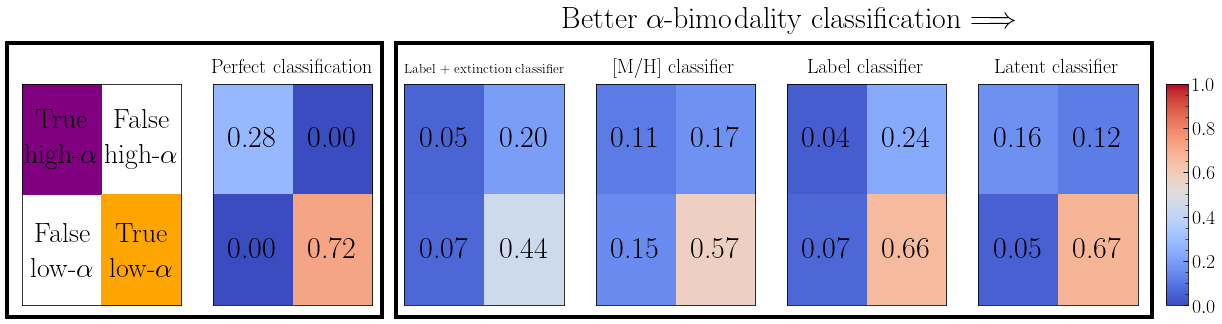

In [94]:
fig, ax = plt.subplots(1,6,figsize=(20,4))
plt.subplots_adjust(wspace=0.2)
cmap = 'coolwarm'
textcolor = 'k'

# plot VAE classifier
ax[5].matshow(cm/len(test_idx), cmap=cmap, alpha=1,vmin=0,vmax=1, aspect="auto")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[5].text(x=j, y=i, s='%.2f' % (cm[i, j]/len(test_idx)), va='center', ha='center', fontsize=30,c=textcolor)

# plot label + extinction classifier
ax[2].matshow(cm4/len(test_idx), cmap=cmap, alpha=1,vmin=0,vmax=1, aspect="auto")
for i in range(cm4.shape[0]):
    for j in range(cm4.shape[1]):
        ax[2].text(x=j, y=i, s='%.2f' % (cm4[i, j]/len(test_idx)), va='center', ha='center', fontsize=30,c=textcolor)

# plot [M/H] classifier
ax[3].matshow(cm2/len(test_idx), cmap=cmap, alpha=1,vmin=0,vmax=1, aspect="auto")
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        ax[3].text(x=j, y=i, s='%.2f' % (cm2[i, j]/len(test_idx)), va='center', ha='center', fontsize=30,c=textcolor)

# plot label classifier
ax[4].matshow(cm3/len(test_idx), cmap=cmap, alpha=1,vmin=0,vmax=1, aspect="auto")
for i in range(cm3.shape[0]):
    for j in range(cm3.shape[1]):
        ax[4].text(x=j, y=i, s='%.2f' % (cm3[i, j]/len(test_idx)), va='center', ha='center', fontsize=30,c=textcolor)

# plot perfect classification
im = ax[1].matshow(cm_perfect/len(test_idx), cmap=cmap, alpha=1,vmin=0,vmax=1, aspect="auto")
for i in range(cm_perfect.shape[0]):
    for j in range(cm_perfect.shape[1]):
        ax[1].text(x=j, y=i, s='%.2f' % (cm_perfect[i, j]/len(test_idx)), va='center', ha='center', fontsize=30,c=textcolor)

# plot labels
names = np.array([[r'False\\low-$\alpha$',r'True\\low-$\alpha$'],[r'True\\high-$\alpha$',r'False\\high-$\alpha$']])
for i in range(cm_perfect.shape[0]):
    for j in range(cm_perfect.shape[1]):
        ax[0].text(x=j, y=i, s=r'\begin{center}%s\end{center}' % names[i,j], va='center', ha='center', fontsize=28,c=textcolor,horizontalalignment='center')
ax[0].set_xlim(-0.5,1.5)
ax[0].set_ylim(-0.5,1.5)

ax[0].fill_between((-1.5,0.5),0.5,1.5,color='purple')
ax[0].fill_between((0.5,1.5),-0.5,0.5,color='orange')

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

fs=20
ax[5].set_title('Latent classifier',fontsize=fs,y=1.02)
ax[3].set_title('[M/H] classifier',fontsize=fs,y=1.02)
ax[4].set_title('Label classifier',fontsize=fs,y=1.02)
ax[2].set_title('Label + extinction classifier',fontsize=fs/1.5,y=1.02)
ax[1].set_title('Perfect classification',fontsize=fs,y=1.02)

pi = ax[3].get_position().get_points().flatten()
ax_cbar_i = fig.add_axes([.92, pi[1], 0.015, pi[3]-pi[1]])
cbar_i = fig.colorbar(im, cax=ax_cbar_i, orientation='vertical',pad=200)

rect1 = plt.Rectangle(
    # (lower-left corner), width, height
    (0.115, 0.07), 0.26, .95, fill=False, color="k", lw=4, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
rect2 = plt.Rectangle(
    # (lower-left corner), width, height
    (0.115+0.27, 0.07), 0.525, .95, fill=False, color="k", lw=4, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect1,rect2])

t = fig.text(0.5,1.1,r'Better $\alpha$-bimodality classification $\Longrightarrow$', ha="left", va="center",
            size=30)

plt.savefig('../figures/confusion_matrices.png',dpi=400,bbox_inches='tight')
plt.show()

### Compute classifier metrics

In [91]:
def accuracy(cm):
    return np.sum(np.diag(cm))/np.sum(cm)

print('Latent: Acc = %.2f' % accuracy(cm))
print('[M/H]: Acc = %.2f' % accuracy(cm2))
print('Label: Acc = %.2f' % accuracy(cm3))
print('Label + Extinction: Acc = %.2f' % accuracy(cm4))

Latent: Acc = 0.84
[M/H]: Acc = 0.68
Label: Acc = 0.70
Label + Extinction: Acc = 0.66


In [92]:
def high_alpha_predictive(cm):
    return cm[0,0]/(cm[0,0]+cm[0,1])

print('Latent: Phigh = %.2f' % high_alpha_predictive(cm))
print('[M/H]: Phigh = %.2f' % high_alpha_predictive(cm2))
print('Label: Phigh = %.2f' % high_alpha_predictive(cm3))
print('Label + Extinction: Phigh = %.2f' % high_alpha_predictive(cm4))

Latent: Phigh = 0.58
[M/H]: Phigh = 0.40
Label: Phigh = 0.15
Label + Extinction: Phigh = 0.22


In [93]:
def low_alpha_predictive(cm):
    return cm[1,1]/(cm[1,0]+cm[1,1])

print('Latent: Plow = %.2f' % low_alpha_predictive(cm))
print('[M/H]: Plow = %.2f' % low_alpha_predictive(cm2))
print('Label: Plow = %.2f' % low_alpha_predictive(cm3))
print('Label + Extinction: Plow = %.2f' % low_alpha_predictive(cm4))

Latent: Plow = 0.93
[M/H]: Plow = 0.79
Label: Plow = 0.91
Label + Extinction: Plow = 0.87
